In [8]:
import pandas as pd
import numpy as np

# --- Load the updated data files ---
kyc = pd.read_csv('mnt/data/kyc.csv')
emt = pd.read_csv('mnt/data/emt.csv')
wire = pd.read_csv('mnt/data/wire.csv')
abm = pd.read_csv('mnt/data/abm.csv')
cheque = pd.read_csv('mnt/data/cheque.csv')
card = pd.read_csv('mnt/data/card.csv')
eft = pd.read_csv('mnt/data/eft.csv')

# --- Tag each dataset with its source ---
emt['source'] = 'EMT'
wire['source'] = 'Wire'
abm['source'] = 'ABM'
cheque['source'] = 'Cheque'
card['source'] = 'Card'
eft['source'] = 'EFT'

# --- Concatenate all transactional datasets ---
all_transactions = pd.concat([emt, wire, abm, cheque, card, eft], ignore_index=True)

# --- Merge with KYC data to get customer details ---
all_transactions = pd.merge(all_transactions, kyc, on="customer_id", how="left")

# --- Ensure 'country' column exists (fill missing with 'Unknown') ---
if 'country' not in all_transactions.columns:
    all_transactions['country'] = 'Unknown'
else:
    all_transactions['country'] = all_transactions['country'].fillna('Unknown')

# Ensure 'city' column exists (fill missing with 'unknown')
if "city" not in all_transactions.columns:
    all_transactions["city"] = "unknown"
else:
    all_transactions["city"] = all_transactions["city"].fillna("unknown")

# --- Basic cleanup: fill missing numeric columns with 0 if needed ---
all_transactions['amount_cad'] = pd.to_numeric(all_transactions['amount_cad'], errors='coerce').fillna(0)
all_transactions['employee_count'] = pd.to_numeric(all_transactions['employee_count'], errors='coerce').fillna(0)
all_transactions['sales'] = pd.to_numeric(all_transactions['sales'], errors='coerce').fillna(0)
all_transactions['industry_code'] = pd.to_numeric(all_transactions['industry_code'], errors='coerce').fillna(0)

# --- Aggregate customer transactions ---
customer_summary = all_transactions.groupby("customer_id").agg({
    "amount_cad": ["sum", "mean", "count"],
    "source": "nunique"
}).reset_index()

customer_summary.columns = [
    "customer_id",
    "total_amount",
    "avg_amount",
    "transaction_count",
    "transaction_types"
]

# --- Define some example "high-risk" industries for illustration ---
high_risk_industries = {129, 7399, 9999}  
# 129 = "Other Animal Specialty Farms n.e.c." (just an example),
# 7399 = "Merchant category unknown or suspicious" (example),
# 9999 = "Any custom code you define as high risk."

# --- Identify suspicious activity ---
suspicious_list = []

# 修改处：使用 customer_summary 计算阈值，而非 all_transactions 中不存在的字段
high_value_threshold = customer_summary["total_amount"].quantile(0.90)
high_frequency_threshold = customer_summary["transaction_count"].quantile(0.90)
# high_value_threshold_cad 可根据需要启用：
high_value_threshold_cad = customer_summary["total_amount"].quantile(0.90)

for _, row in customer_summary.iterrows():
    suspicious_types = []
    
    # Retrieve all transactions for this customer
    customer_txns = all_transactions[all_transactions["customer_id"] == row["customer_id"]]
    
    # 1. High Value Transactions
    if row["total_amount"] > high_value_threshold:
        suspicious_types.append(
             f"High Value Transactions: total_amount > {high_value_threshold:.2f} CAD"
        )
        
    # 2. High Frequency Transactions
    if row["transaction_count"] > high_frequency_threshold:
        suspicious_types.append(
            f"High Frequency Transactions: transaction_count > {high_frequency_threshold:.2f}"
        )
        
    # 3. Structuring (Smurfing) - multiple transactions just below 10K
    # structuring_count = customer_txns[
    #     (customer_txns["amount_cad"] >= 9000) & (customer_txns["amount_cad"] < 10000)
    # ].shape[0]
    # if structuring_count > 5:
    #     suspicious_types.append(
    #         "Structuring (Smurfing): more than 5 transactions in the 9K-10K range"
    #     )
        
    # 4. High-Risk Industry with Large Volume
    customer_industry = customer_txns["industry_code"].unique()
    if any(ind in high_risk_industries for ind in customer_industry) and row["total_amount"] > high_value_threshold:
        suspicious_types.append(
            f"High-Risk Industry + Large Volume: industry_code in high_risk_industries & total_amount > {high_value_threshold:.2f}"
        )
    
    # 5. Inconsistent with Business Profile:
    if (customer_txns["employee_count"].max() <= 0 or customer_txns["sales"].max() <= 0) and row["total_amount"] >  high_value_threshold:
        suspicious_types.append(
            "Inconsistent Business Profile: no employees or sales, yet large transaction volume"
        )
    
    # 6. Large Cash (ABM) Transactions
    abm_txns = customer_txns[customer_txns["source"] == "ABM"]
    if not abm_txns.empty:
        large_abm_count = abm_txns[abm_txns["amount_cad"].abs() > 1000000].shape[0]
        if large_abm_count > 0:
            suspicious_types.append(
                f"Large Cash (ABM) Transactions: {large_abm_count} ABM transaction(s) over 1,000,000 CAD"
            )
    
    # 7. Negative or Reversed Transactions
    negative_count = customer_txns[customer_txns["amount_cad"] < -1000].shape[0]
    if negative_count > 3:
        suspicious_types.append(
            "Multiple Negative Transactions: potential reversals or refunds more than 1000"
        )
    
    # 8. Missing or Sparse KYC Info
    if customer_txns["city"].isnull().all() or customer_txns["city"].eq('other').all():
        if row["total_amount"] > 20000:
            suspicious_types.append(
                "Sparse KYC + Large Volume: city is missing/'other' yet high total amount"
            )
    
    # If any suspicious types were detected, record them
    if suspicious_types:
        suspicious_list.append({
            "customer_id": row["customer_id"],
            "suspicious_activity": " | ".join(suspicious_types)
        })

# --- Convert to DataFrame and save to CSV ---
suspicious_df = pd.DataFrame(suspicious_list)
suspicious_df.to_csv("mnt/data/suspicious_customers.csv", index=False)

print("Suspicious customer records saved in 'suspicious_customers.csv'")


Suspicious customer records saved in 'suspicious_customers.csv'


f:\Programming\anaconda3\envs\cvlab_env\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


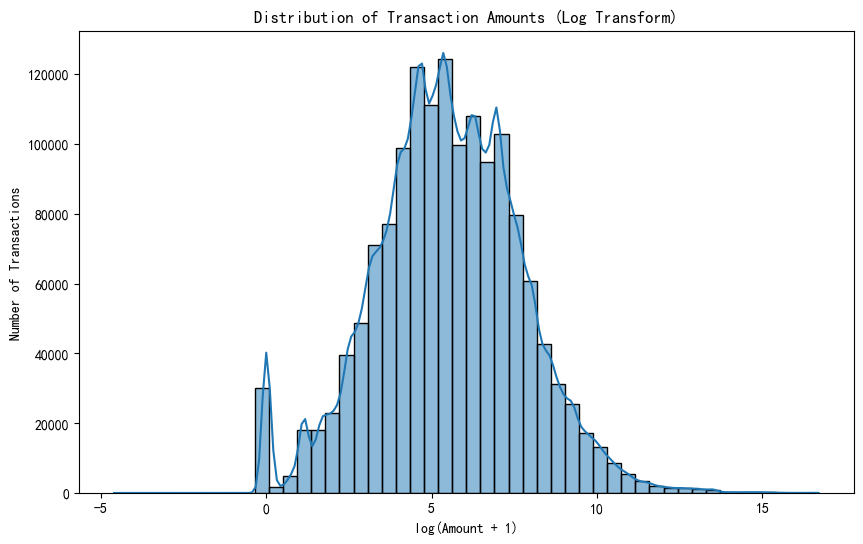

f:\Programming\anaconda3\envs\cvlab_env\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


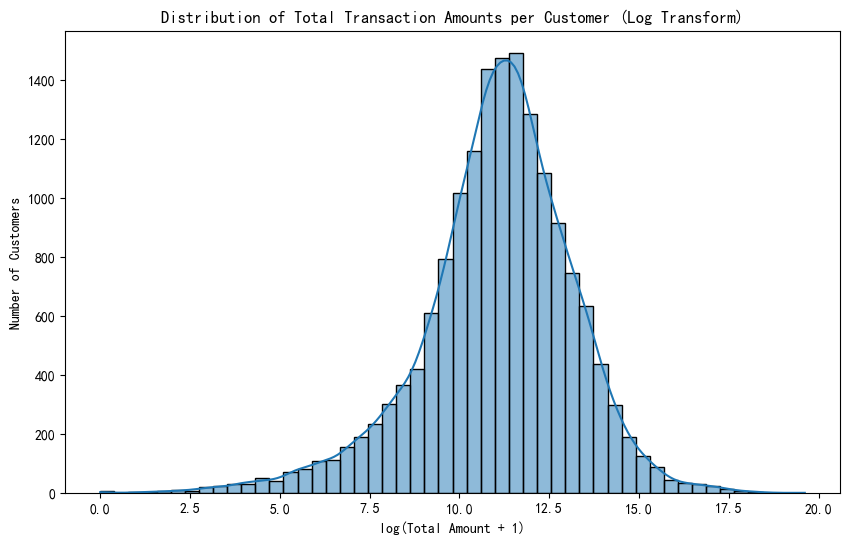

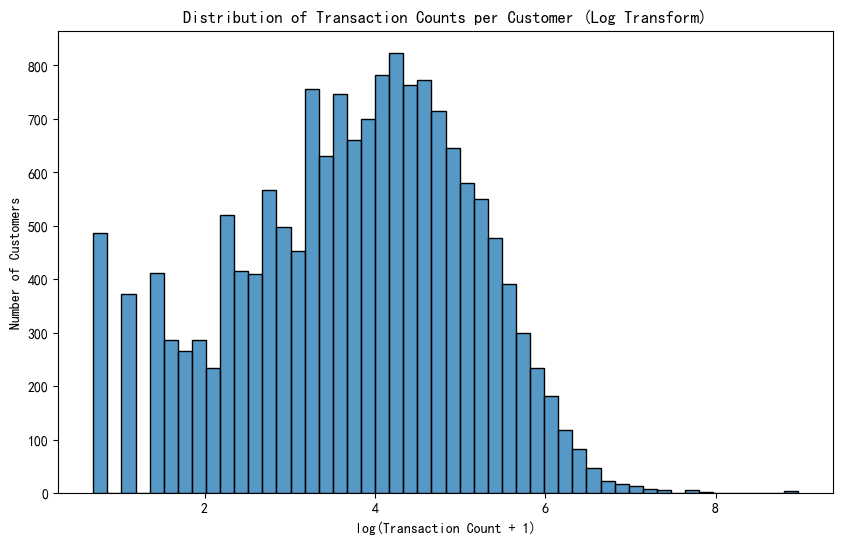

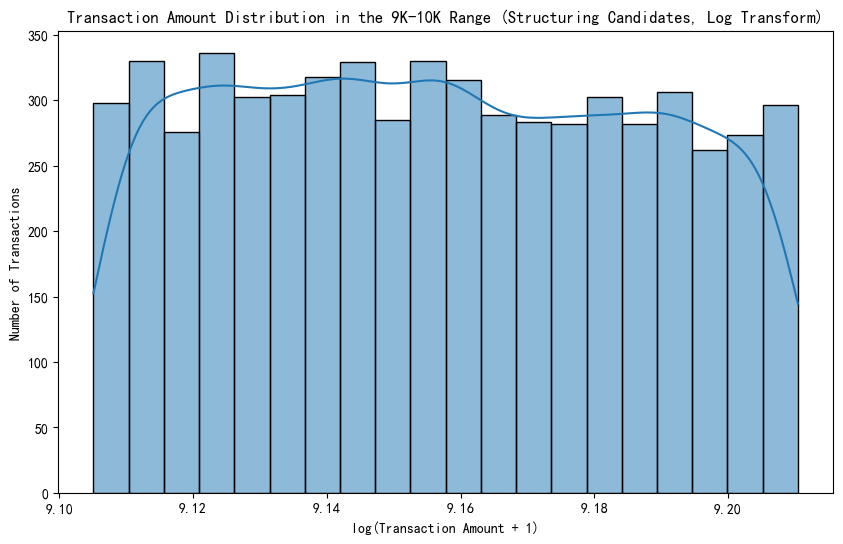

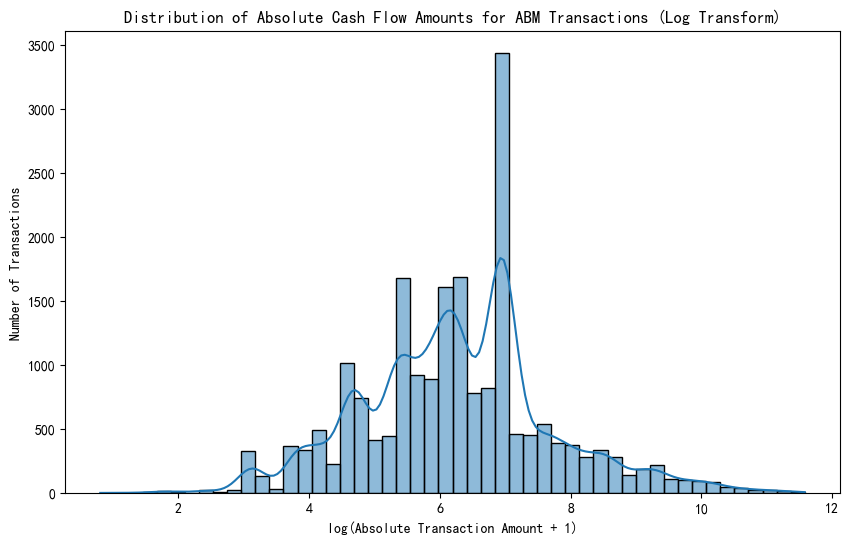

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Load updated data files ---
kyc = pd.read_csv('mnt/data/kyc.csv')
emt = pd.read_csv('mnt/data/emt.csv')
wire = pd.read_csv('mnt/data/wire.csv')
abm = pd.read_csv('mnt/data/abm.csv')
cheque = pd.read_csv('mnt/data/cheque.csv')
card = pd.read_csv('mnt/data/card.csv')
eft = pd.read_csv('mnt/data/eft.csv')

# --- Tag each dataset with its source ---
emt['source'] = 'EMT'
wire['source'] = 'Wire'
abm['source'] = 'ABM'
cheque['source'] = 'Cheque'
card['source'] = 'Card'
eft['source'] = 'EFT'

# --- Concatenate all transactional datasets ---
all_transactions = pd.concat([emt, wire, abm, cheque, card, eft], ignore_index=True)

# --- Merge with KYC data to get customer details ---
all_transactions = pd.merge(all_transactions, kyc, on="customer_id", how="left")

# --- Ensure the 'country' column exists (fill missing with 'Unknown') ---
if 'country' not in all_transactions.columns:
    all_transactions['country'] = 'Unknown'
else:
    all_transactions['country'] = all_transactions['country'].fillna('Unknown')

# --- Ensure the 'city' column exists (fill missing with 'unknown') ---
if "city" not in all_transactions.columns:
    all_transactions["city"] = "unknown"
else:
    all_transactions["city"] = all_transactions["city"].fillna("unknown")

# --- Basic cleanup: convert numeric columns and fill missing values with 0 ---
all_transactions['amount_cad'] = pd.to_numeric(all_transactions['amount_cad'], errors='coerce').fillna(0)
all_transactions['employee_count'] = pd.to_numeric(all_transactions['employee_count'], errors='coerce').fillna(0)
all_transactions['sales'] = pd.to_numeric(all_transactions['sales'], errors='coerce').fillna(0)
all_transactions['industry_code'] = pd.to_numeric(all_transactions['industry_code'], errors='coerce').fillna(0)

# --- Aggregate customer transactions ---
customer_summary = all_transactions.groupby("customer_id").agg({
    "amount_cad": ["sum", "mean", "count"],
    "source": "nunique"
}).reset_index()

customer_summary.columns = [
    "customer_id",
    "total_amount",
    "avg_amount",
    "transaction_count",
    "transaction_types"
]

# --- Define some example "high-risk" industries for illustration ---
high_risk_industries = {129, 7399, 9999}  

# Set Chinese font (adjust based on your system if needed)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# Use logarithmic transformation np.log1p (suitable for data that may include 0)

# 1. Distribution of transaction amounts for all transactions (log transform)
plt.figure(figsize=(10, 6))
log_amount = np.log1p(all_transactions['amount_cad'])
sns.histplot(log_amount, bins=50, kde=True)
plt.title("Distribution of Transaction Amounts (Log Transform)")
plt.xlabel("log(Amount + 1)")
plt.ylabel("Number of Transactions")
plt.show()

# 2. Distribution of total transaction amounts per customer (log transform)
plt.figure(figsize=(10, 6))
log_total_amount = np.log1p(customer_summary['total_amount'])
sns.histplot(log_total_amount, bins=50, kde=True)
plt.title("Distribution of Total Transaction Amounts per Customer (Log Transform)")
plt.xlabel("log(Total Amount + 1)")
plt.ylabel("Number of Customers")
plt.show()

# 3. Distribution of transaction counts per customer (log transform)
plt.figure(figsize=(10, 6))
log_txn_count = np.log1p(customer_summary['transaction_count'])
sns.histplot(log_txn_count, bins=50, kde=False)
plt.title("Distribution of Transaction Counts per Customer (Log Transform)")
plt.xlabel("log(Transaction Count + 1)")
plt.ylabel("Number of Customers")
plt.show()

# 4. Structuring (Smurfing) - transactions in the 9K-10K range (log transform)
structuring_txns = all_transactions[(all_transactions["amount_cad"] >= 9000) & (all_transactions["amount_cad"] < 10000)]
plt.figure(figsize=(10, 6))
log_structuring = np.log1p(structuring_txns['amount_cad'])
sns.histplot(log_structuring, bins=20, kde=True)
plt.title("Transaction Amount Distribution in the 9K-10K Range (Structuring Candidates, Log Transform)")
plt.xlabel("log(Transaction Amount + 1)")
plt.ylabel("Number of Transactions")
plt.show()

# 5. Distribution of absolute cash flow amounts for ABM transactions (log transform)
abm_txns = all_transactions[all_transactions["source"] == "ABM"]
plt.figure(figsize=(10, 6))
log_abm = np.log1p(abm_txns['amount_cad'].abs())
sns.histplot(log_abm, bins=50, kde=True)
plt.title("Distribution of Absolute Cash Flow Amounts for ABM Transactions (Log Transform)")
plt.xlabel("log(Absolute Transaction Amount + 1)")
plt.ylabel("Number of Transactions")
plt.show()
